In [1]:
# inversion calculation
# following Feng 2009 ACP paper

In [2]:
# to display plots in notebook
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 300  # high res plots
rcParams["font.size"] = 12

import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import re
import cartopy.crs as ccrs
import pandas as pd
from gamap_colormap import WhGrYlRd  # import the "WhGrYlRd" variable from my custom Python script

In [4]:
case_name  = 'CO2-2018-01'
name_month = 'Jan' # Jan, Feb, Mar
imonth     =  1    # 1,2,3
mode       = 'N'  # 'N': Nadir or 'NG': Nadir + Glint

In [5]:
case_dir = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/' + case_name + '/nd51/'
output_dir = case_dir
xco2_dir = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/CO2-2018/nd51/'

if mode == 'N':
    delta_y0_file = 'delta_y0_model_N_' + str(imonth) + '.nc'
    xco2_file = 'XCO2_mod_and_oco2_N_' + name_month + '.nc'
else:
    delta_y0_file = 'delta_y0_model_' + str(imonth) + '.nc'
    xco2_file = 'XCO2_mod_and_oco2_' + name_month + '.nc'

In [6]:
ds_delta_y0 = xr.open_dataset(case_dir + delta_y0_file)
varnames = list(ds_delta_y0.data_vars.keys())

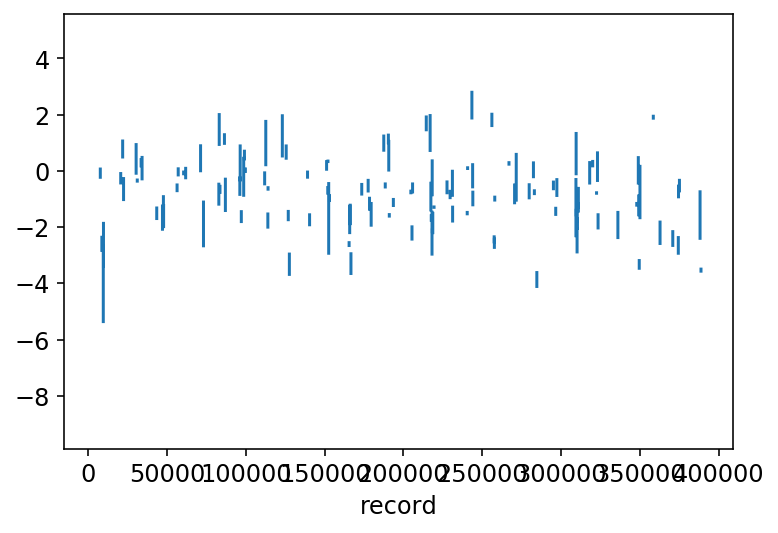

In [7]:
ds_xco2 = xr.open_dataset(xco2_dir + xco2_file)
diff = ds_xco2['xco2_oco2'] - ds_xco2['xco2_model']
diff.plot()

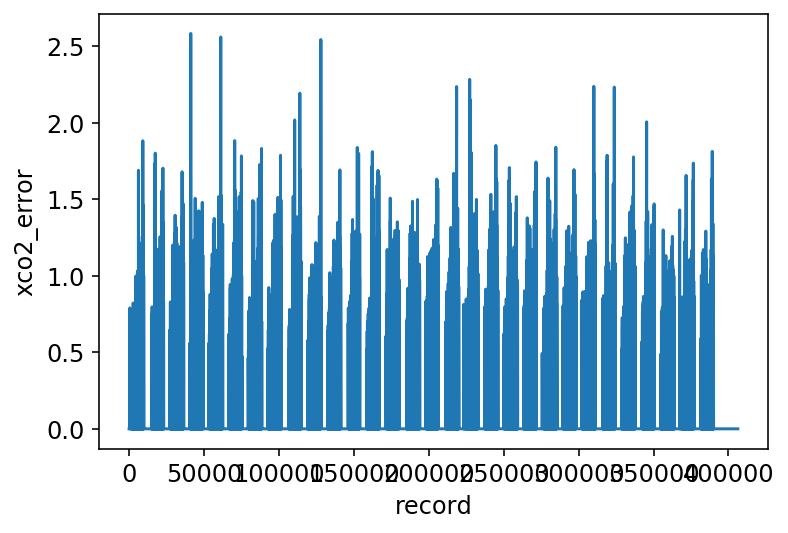

In [8]:
xco2_error = ds_xco2['xco2_error']
xco2_error.plot()

In [9]:
# reduce the size of all arrays and matrices, from 400k to <5k
xco2_oco2 = ds_xco2['xco2_oco2']
x = xco2_oco2.copy()
x = x[np.logical_not(np.isnan(x))]
ind = x.record.values # index for slicing
length = len(ind)
length

1554

(1554,)


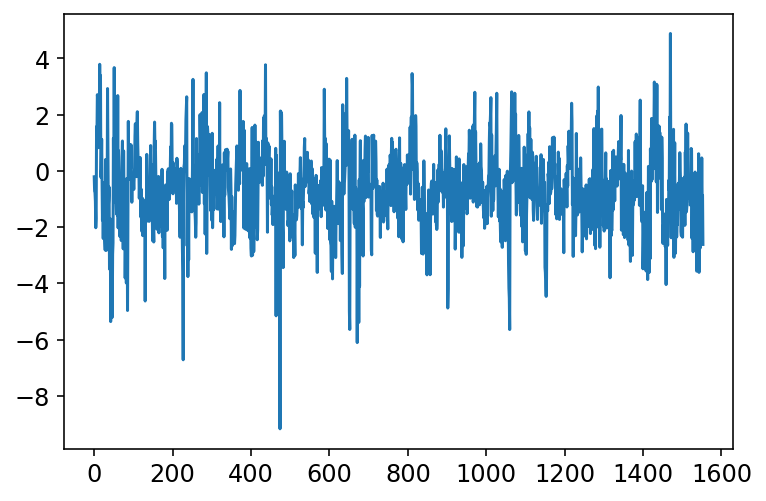

In [10]:
diff_slice = diff[ind].values
print(np.shape(diff_slice))
plt.plot(diff_slice) # same as above, excluded nan values

1554


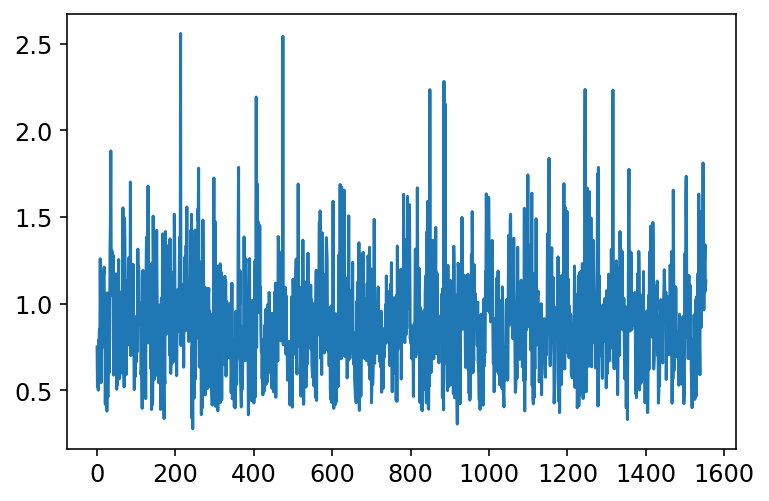

In [11]:
xco2_error_slice = xco2_error[ind].values
print(len(xco2_error_slice))
plt.plot(xco2_error_slice) # same as above, excluded nan values

In [12]:
del_Y_matrix = np.empty((length,22))
del_Y_matrix[:] = np.nan
print(np.shape(del_Y_matrix))

for itag in range(22):
    name_var = 'X_SpeciesConc_CO2Tag' + str(itag+1)
    del_Y_matrix[:,itag] = ds_delta_y0[name_var][ind].values

(1554, 22)


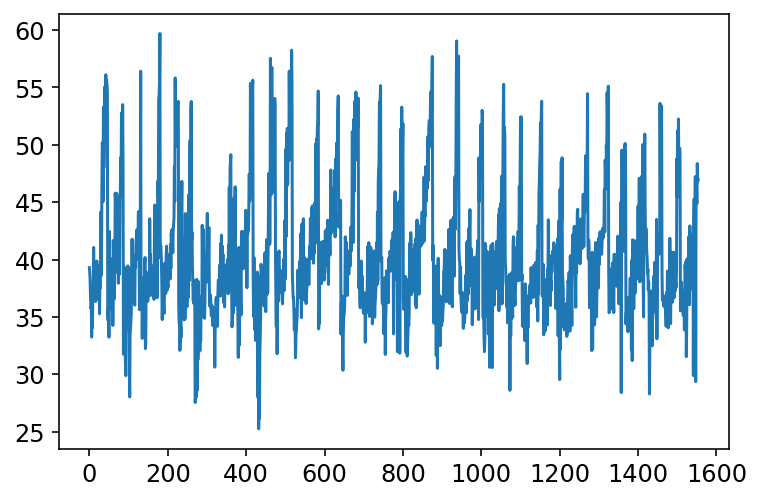

In [13]:
plt.plot(del_Y_matrix[:,5])

In [14]:
del_Y_tran = np.matrix.transpose(del_Y_matrix)
first = np.matmul(del_Y_matrix,del_Y_tran)
print(np.shape(first))
first

(1554, 1554)


array([[33963.92228043, 33648.26424274, 32999.24527285, ...,
        41756.80489121, 40467.76540329, 40619.60801344],
       [33648.26424274, 33335.539907  , 32692.55286977, ...,
        41368.72044492, 40091.66120129, 40242.09260039],
       [32999.24527285, 32692.55286977, 32061.96798296, ...,
        40570.78677872, 39318.35989762, 39465.8897287 ],
       ...,
       [41756.80489121, 41368.72044492, 40570.78677872, ...,
        51337.78329645, 49752.98166991, 49939.65953574],
       [40467.76540329, 40091.66120129, 39318.35989762, ...,
        49752.98166991, 48217.26646387, 48398.17412657],
       [40619.60801344, 40242.09260039, 39465.8897287 , ...,
        49939.65953574, 48398.17412657, 48579.77391509]])

In [15]:
obs_error = np.zeros((length,length))
print(np.shape(obs_error))
for idiag in range(length):
    obs_error[idiag, idiag] = xco2_error_slice[idiag]**2 + 2.5 #
obs_error

(1554, 1554)


array([[3.0637276 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.77181753, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 2.90539968, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 4.29709238, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 3.65320331,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        3.78290335]])

In [16]:
second = np.linalg.inv(first+obs_error)
second

array([[ 3.26047024e-01, -3.86200457e-04, -3.61241199e-04, ...,
        -1.50796895e-04, -1.13542748e-04, -8.98562468e-05],
       [-3.86200457e-04,  3.60351206e-01, -3.95675782e-04, ...,
        -1.65682596e-04, -1.25033477e-04, -9.92908905e-05],
       [-3.61241199e-04, -3.95675782e-04,  3.43816388e-01, ...,
        -1.55725532e-04, -1.17897253e-04, -9.40666448e-05],
       ...,
       [-1.50796895e-04, -1.65682596e-04, -1.55725532e-04, ...,
         2.32246401e-01, -2.03369929e-04, -1.77948607e-04],
       [-1.13542748e-04, -1.25033477e-04, -1.17897253e-04, ...,
        -2.03369928e-04,  2.72442626e-01, -1.53527626e-03],
       [-8.98562464e-05, -9.92908899e-05, -9.40666448e-05, ...,
        -1.77948608e-04, -1.53527626e-03,  2.62375275e-01]])

In [17]:
third = np.matmul(del_Y_tran,second)
print(np.shape(third))
third

(22, 1554)


array([[ 2.28792885e-04,  9.17456757e-06, -3.01570607e-04, ...,
        -1.64487548e-03, -2.07862331e-03, -2.65855786e-03],
       [ 2.67821347e-05,  4.46823690e-05,  6.15477748e-05, ...,
        -1.06992471e-03, -1.53159590e-03, -2.04859096e-03],
       [-5.95139020e-04, -6.33357070e-04, -5.69002367e-04, ...,
        -1.22084146e-03, -1.54105899e-03, -1.94698769e-03],
       ...,
       [-1.29120362e-04, -1.27785335e-04, -1.02068145e-04, ...,
        -1.41472377e-03, -8.48690911e-04, -1.31394586e-03],
       [ 1.96256605e-03,  2.17259045e-03,  2.06295565e-03, ...,
        -8.08063491e-04,  2.24691357e-03,  2.05952413e-03],
       [-2.60699195e-05, -3.31821434e-06,  2.93964891e-05, ...,
         3.82608362e-03,  4.55286461e-03,  4.87735645e-03]])

In [18]:
del_X_f = np.zeros((22,22))
for idiag in range(22):
    del_X_f[idiag,idiag] = 1.0  # GtC/yr
del_X_f_inv = np.linalg.inv(del_X_f)

In [19]:
k_e = np.matmul(del_X_f,third)
print(np.shape(k_e))
k_e

(22, 1554)


array([[ 2.28792885e-04,  9.17456757e-06, -3.01570607e-04, ...,
        -1.64487548e-03, -2.07862331e-03, -2.65855786e-03],
       [ 2.67821347e-05,  4.46823690e-05,  6.15477748e-05, ...,
        -1.06992471e-03, -1.53159590e-03, -2.04859096e-03],
       [-5.95139020e-04, -6.33357070e-04, -5.69002367e-04, ...,
        -1.22084146e-03, -1.54105899e-03, -1.94698769e-03],
       ...,
       [-1.29120362e-04, -1.27785335e-04, -1.02068145e-04, ...,
        -1.41472377e-03, -8.48690911e-04, -1.31394586e-03],
       [ 1.96256605e-03,  2.17259045e-03,  2.06295565e-03, ...,
        -8.08063491e-04,  2.24691357e-03,  2.05952413e-03],
       [-2.60699195e-05, -3.31821434e-06,  2.93964891e-05, ...,
         3.82608362e-03,  4.55286461e-03,  4.87735645e-03]])

In [20]:
adjust = np.matmul(k_e, diff_slice)
adjust

array([ 0.37598559, -0.7521686 ,  0.63838945, -0.1307684 , -0.13432776,
       -0.81233927, -0.54235724,  0.46188019,  0.41926551, -1.9487599 ,
       -1.58974351,  1.58197327,  1.09309707,  2.71140461,  0.42450449,
        0.25835454, -1.08697184, -0.37137873, -1.11570245,  0.65044068,
        0.07370468, -0.21510094])

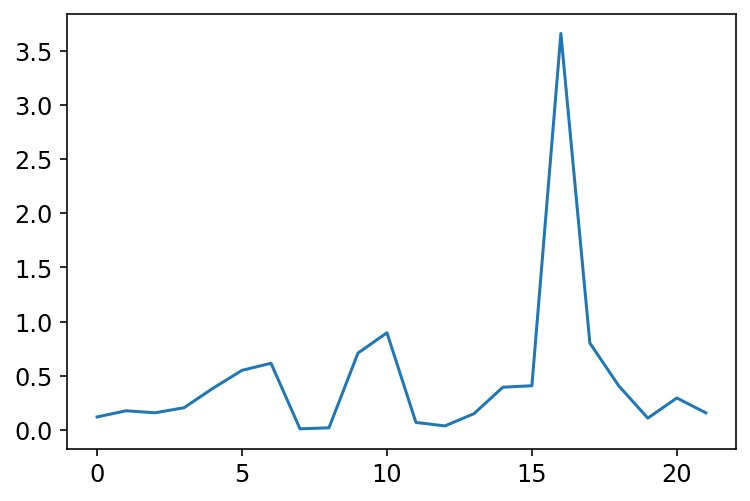

In [21]:
df = pd.read_csv('/geos/u73/msadiq/GEOS-Chem/analysis/inversion/data/base_emission.csv')
region_names = df['name'].values
prior_emission = df['emission'].values
plt.plot(prior_emission)

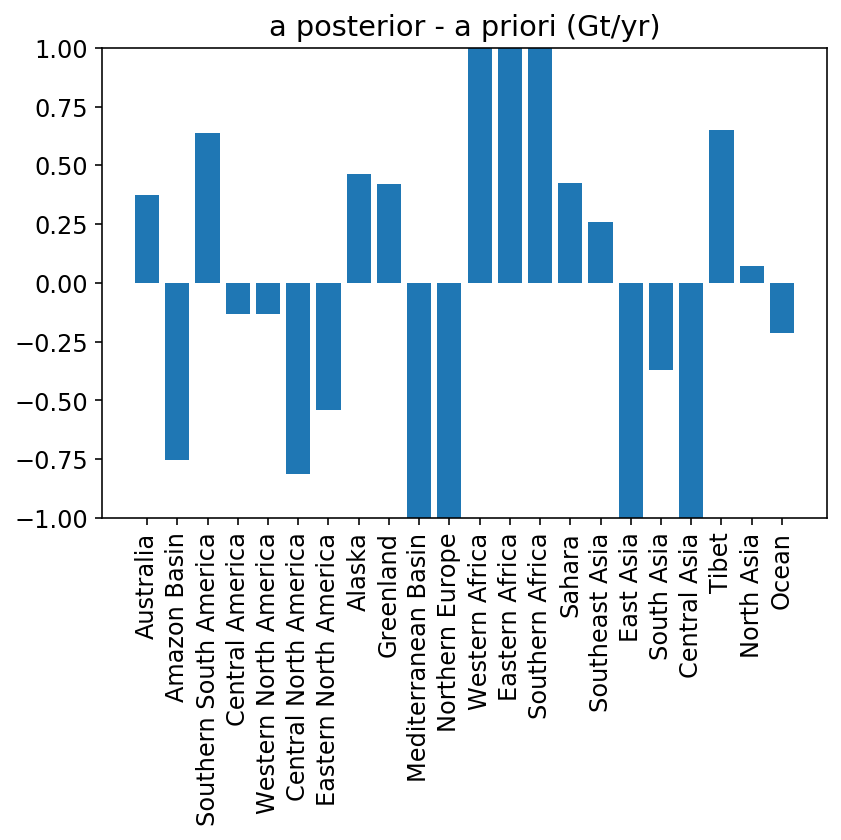

In [22]:
# first attempt
fig = plt.figure(figsize=[6, 6])
plt.bar(region_names, adjust)
plt.ylim(top   = 1,bottom = -1)
plt.title('a posterior - a priori (Gt/yr)')
plt.xticks(rotation=90)
fig.tight_layout()

fig.savefig(output_dir+'adjustment_' + name_month +'.png', dpi=300)

shape of k_e:  (22, 1554)


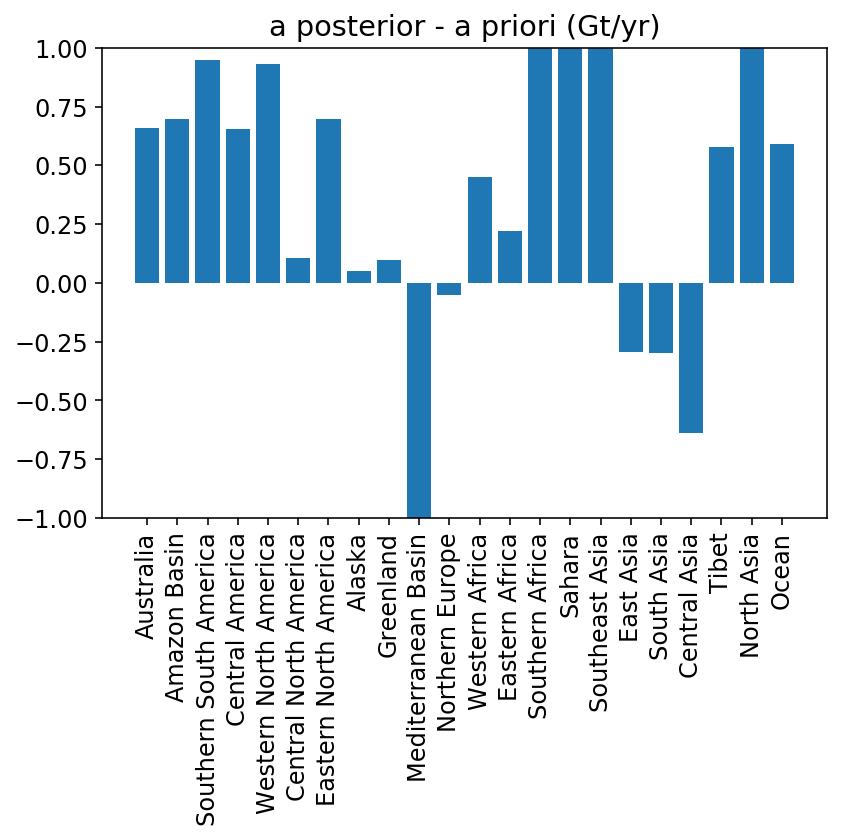

In [23]:
# different algorithm
X_f = np.zeros((22,22))
for idiag in range(22):
    X_f[idiag,idiag] = prior_emission[idiag]
mul1 = np.matmul(del_X_f_inv, X_f)
del_Y = np.matmul(del_Y_matrix, mul1)
Y_tran = np.matrix.transpose(del_Y)
first = np.matmul(del_Y,Y_tran)
second = np.linalg.inv(first+obs_error)
third = np.matmul(Y_tran,second)
k_e = np.matmul(del_X_f,third)
print('shape of k_e: ', k_e.shape)
adjust = np.matmul(k_e, diff_slice)

fig = plt.figure(figsize=[6, 6])
plt.bar(region_names, adjust)
plt.ylim(top   = 1,bottom = -1)
plt.title('a posterior - a priori (Gt/yr)')
plt.xticks(rotation=90)
fig.tight_layout()

fig.savefig(output_dir+'adjustment_' + name_month +'.png', dpi=300)

In [24]:
sum(adjust)

9.266145157264459

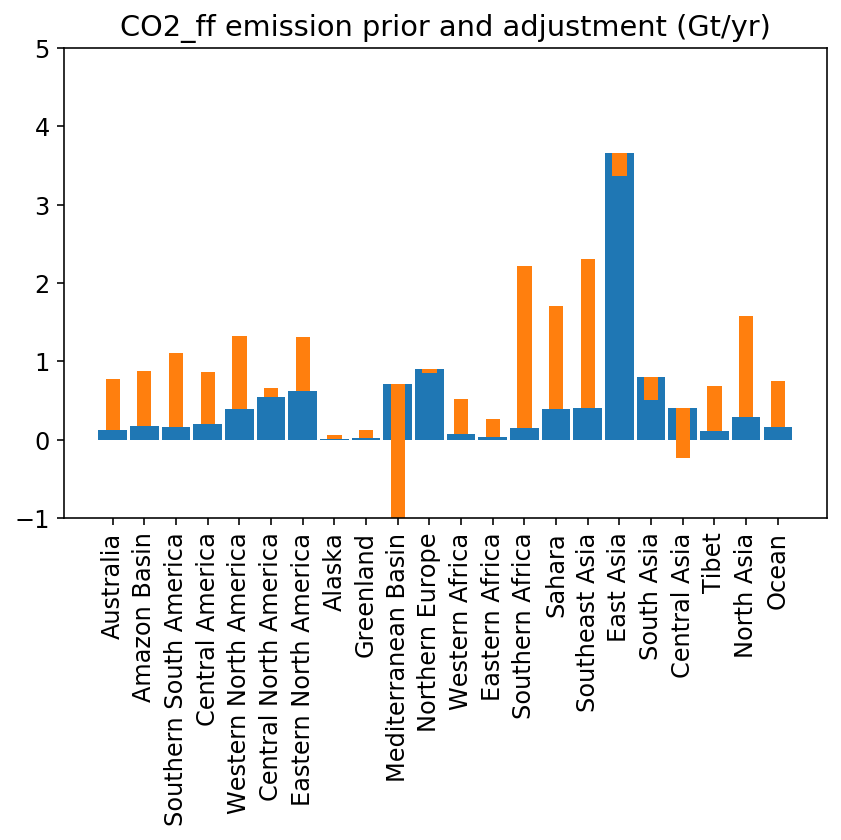

In [25]:
fig = plt.figure(figsize=[6, 6])
width = 0.9
plt.bar(region_names, prior_emission, width)
plt.bar(region_names, adjust,         width*0.5, bottom = prior_emission)
plt.ylim(top   = 5,bottom = -1)
plt.title('CO2_ff emission prior and adjustment (Gt/yr)')
plt.xticks(rotation=90)
fig.tight_layout()

fig.savefig(output_dir+'posterior_' + name_month +'.png', dpi=300)